# The Flatten The Curve and Herd Immunity Corona model
This modified SIR toy model simulates a Corona outbreak.




In [27]:
#This is the SIRD model
#A simple differential equation
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def SIRD(population, initial_infected, beta,gamma,death_rate,death_rate_without_healthcare,health_care_capacity):

    # Population, initial infected, initial susceptible. 
    N = population
    I0, R0 = initial_infected, 0
    D0 = 0
    S0 = N - I0 - R0
    t = np.linspace(0, 1000, 1000)

    # The SIRd model differential equations.
    def deriv_death(y, t, N, beta, gamma,  death_rate, health_care_capacity, death_rate_without_healthcare):
        S, I, R, D = y
        dSdt = (-beta * S * I) / N
        
        #This is an addition to the SIR model:
        # A certain population who is sick dies when treated.
        # There are finite hospital beds. People who are not treated die at a higher rate.
        dDdt = death_rate*I
        if I > health_care_capacity:
            untreated_infected = I - health_care_capacity
            dDdt +=  death_rate_without_healthcare*untreated_infected
        dIdt = beta * S * I / N - gamma * I - dDdt
        dRdt = gamma * I

        return dSdt, dIdt, dRdt, dDdt

    y0 = S0, I0, R0, D0
    ret = odeint(deriv_death, y0, t, args=(N, beta, gamma, death_rate,health_care_capacity,death_rate_without_healthcare))
    S, I, R, D = ret.T

    return t,S,I,R,D



#This is code for plotting and looking at the results.

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
from ipywidgets import IntSlider

print("This runs a simple epidemics differential equation model using different parameters.")
print("This assumes that we can keep down infection rate by social distancing, and evaluates the results.")
print()
print("population - total population in thousands")
print("initial_infected - the seed number of infected (e.g. if you want to try social distancing after some days)")
print("infection_rate - how many does an infected on average spead to")
print("mortality - fraction infected dead with care.")
print("mortality_no_care - fraction infected without care.")
print("care_beds - number of intensive care beds")
print()
print("Default settings are for the US, and approximate values available from online sources.")



@interact(population=widgets.IntSlider(min=0, max=500000, step=500, value=320000,style=style),
          initial_infected=widgets.IntSlider(min=0, max=500000, step=500, value=1),
                infection_rate=FloatSlider(min=0.8, max=4, step=0.01,value=2.3),
                mortality=FloatSlider(min=0.01, max=0.1, step=0.005,value=0.005),
                mort_no_care=FloatSlider(min=0.01, max=0.2, step=0.005,value=0.05,style=style),
                care_beds=IntSlider(min=0, max=1000, step=1,value=80))
def plot_curve(population=320000,initial_infected=1,infection_rate=2.5, mortality=0.01, mort_no_care=0.05, care_beds=2000):
    
    days_sick = 10
    gamma = 1./days_sick
    death_rate = mortality / days_sick
    death_rate_without_healthcare = mort_no_care / days_sick
    
    #Only people who would otherwise die need beds
    health_care_capacity = (care_beds / death_rate_without_healthcare) / days_sick
    beta = infection_rate/days_sick
    
    t,S,I,R,D = SIRD(population,initial_infected,beta,gamma,death_rate,death_rate_without_healthcare,health_care_capacity)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)

    #ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.5, lw=2, label='Infected')
    #ax.plot(t, R, 'b', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, D, 'r', alpha=0.5, lw=2, label='Dead')
    ax.axhline(health_care_capacity, color='g', linestyle='-', label="Health care capacity")

    ax.set_ylim(0,max(max(I),max(D)))

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    plt.ylabel('Population (thousand)')
    plt.xlabel('Days since first infection')

    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    
    finaldead = D[len(D)-1]
    finalrecovered = R[len(R)-1]
    print("Total dead: " + str(int(round(finaldead))) + " thousand of " + str(population)+ " thousands. " + str(int(100*finaldead/population)) + "% of population." )
    print("Infected but recovered: " + str(int(round(finalrecovered))) + " thousand. " + str(int(100*finalrecovered/population)) + "% of population." )
    
    
    



This runs a simple epidemics differential equation model using different parameters.
This assumes that we can keep down infection rate by social distancing, and evaluates the results.

population - total population in thousands
initial_infected - the seed number of infected (e.g. if you want to try social distancing after some days)
infection_rate - how many does an infected on average spead to
mortality - fraction infected dead with care.
mortality_no_care - fraction infected without care.
care_beds - number of intensive care beds

Default settings are for the US, and approximate values available from online sources.


interactive(children=(IntSlider(value=320000, description='population', max=500000, step=500, style=SliderStyl…

# Animation of varying spread rate

In [9]:
#This code animates the result, with varying infection rate.

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.writer'] = 'ffmpeg'

betas=[]
deads=[]

fig, ax = plt.subplots()

plt.xlabel('time')
plt.ylabel('population')

ax.set_xlim(( 0, 700))
ax.set_ylim(0,4)

ax.set_yticklabels([])
ax.set_xticklabels([])

line, = ax.plot([], [], lw=2)

lines = []
for index in range(3):
    lobj = ax.plot([],[],lw=2,color=['black','red','green'][index],label=['Infected','Dead','Healthcare capacity'][index])[0]
    lines.append(lobj)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

def init():
    for line in lines:
        line.set_data([],[])
    return lines


def animate(i):
    x1,y1 = [],[]
    x2,y2 = [],[]
    x3,y3 = [],[]

    beta, gamma = 0.14, 1./10
    death_rate = 0.01/10
    death_rate_without_healthcare = 0.1/10
    health_care_capacity = 2000
    beta2 = beta-i/2500
    t,S,I,R,D = SIRD(beta2,gamma,death_rate,death_rate_without_healthcare,health_care_capacity)
    
    #Save the beta value and the final death rate for separate plotting
    betas.append(beta2)
    deads.append(D[len(D)-1])

    x = t
    y = I/1000
    x1.append(x)
    y1.append(y)

    x = t
    y = D/1000
    x2.append(x)
    y2.append(y)
    x = t
    y = len(t)*[health_care_capacity/1000]
    x3.append(x)
    y3.append(y)

    xlist = [x1, x2, x3]
    ylist = [y1, y2, y3]

    for lnum,line in enumerate(lines):
        line.set_data(xlist[lnum], ylist[lnum])

    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=80, interval=30, blit=False)

HTML(anim.to_html5_video())


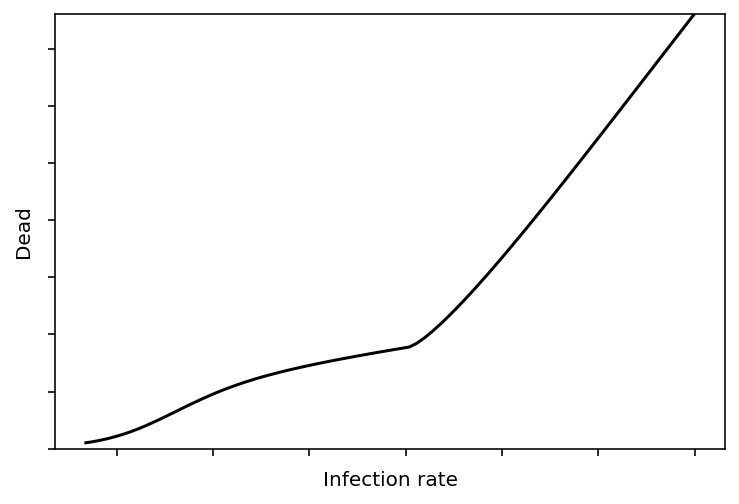

In [10]:
#Plot the death rate as a runfciton of infection rate, to show nonlinearity
fig, ax = plt.subplots()
plt.ylabel('Dead')
plt.xlabel('Infection rate')
plt.ylim(0,max(deads))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.plot(betas,deads,color='black')